In [3]:
import nltk
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

In [4]:
#This cell is need to mount the drive for the dataset if want to run from colab, else read_csv cannot locate the data file
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
wbs_df=pd.read_csv('./website_classification.csv')
#wbs_df=pd.read_csv('/content/drive/MyDrive/website_classification.csv')
wbs_df.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [6]:
print('Shape of dataframe:',wbs_df.shape)
print('Columns in dataframe:',wbs_df.columns)
wbs_df.Category.value_counts()

Shape of dataframe: (1408, 4)
Columns in dataframe: Index(['Unnamed: 0', 'website_url', 'cleaned_website_text', 'Category'], dtype='object')


Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
Health and Fitness                  96
News                                96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: Category, dtype: int64

In [7]:
wbs_df.drop('Unnamed: 0',axis=1,inplace=True)   #Dropping the unnecessary column
wbs_df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


### Check for null values

In [8]:
#Checking whether there are any null values.
wbs_df.isnull().sum()   

website_url             0
cleaned_website_text    0
Category                0
dtype: int64

In [9]:
wbs_df.Category.unique()

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Forums', 'Food', 'Education', 'Computers and Technology',
       'Business/Corporate', 'Adult'], dtype=object)

In [10]:
wbs_df.Category.value_counts()

Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
Health and Fitness                  96
News                                96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: Category, dtype: int64

### Adult and Forums category sample size is very small (only 16 website) compare to the other category. Remove "Adult" and "Forums" category for this website classification

In [11]:
wbs_df = wbs_df.loc[(wbs_df["Category"] != "Adult") & (wbs_df["Category"] != "Forums")]
#wbs_df = wbs_df.loc[(wbs_df["Category"] != "Social Networking and Messaging") & (wbs_df["Category"] != "Streaming Services") & (wbs_df["Category"] != "Games")]
wbs_df.shape
wbs_df.Category.unique()

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Food', 'Education', 'Computers and Technology',
       'Business/Corporate'], dtype=object)

In [12]:
num_of_category = 0
  
# list to hold exist category
exist = []
  
# loop for counting the unique
# values in category
for i in wbs_df['Category'].index:
    if wbs_df['Category'][i] not in exist: 
        exist.append(wbs_df['Category'][i])
        num_of_category += 1
  
print("No.of.unique values :",num_of_category)

No.of.unique values : 14


### EDA

Text(0, 0.5, 'Website Category')

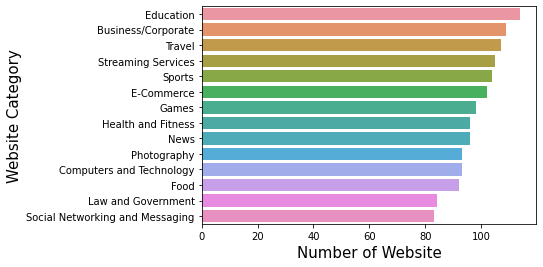

In [13]:
plot = sns.countplot(y=wbs_df['Category'], order=wbs_df['Category'].value_counts().index[:num_of_category])
plt.xlabel("Number of Website",fontsize=15)
plt.ylabel("Website Category", fontsize=15)

### Give an ID to each category, for predictive model to better differentiate the categories.

In [14]:
# Create a new column for 'category_id' with a value 
wbs_df['CategoryID'] = wbs_df['Category'].factorize()[0]
category_with_id_df = wbs_df[['Category', 'CategoryID']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_with_id_df.values)
id_to_category = dict(category_with_id_df[['CategoryID', 'Category']].values)

# Check new dataframe with the category_id
#wbs_df.head()

In [15]:
category_with_id_df

,Category,CategoryID
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


In [16]:
wordsum = [0]*num_of_category
for c in id_to_category:
    numOfWebsite = 0
    for i in wbs_df['Category'].index:
        if (wbs_df['Category'][i]==id_to_category[c]):
            numberOfELement= len(wbs_df['cleaned_website_text'][i].split())
            wordsum[c]=wordsum[c]+numberOfELement
            numOfWebsite = numOfWebsite + 1
    print('There are', numOfWebsite, 'website for',id_to_category[c],'category. Total number of words for this category is : ', wordsum[c])

There are 107 website for Travel category. Total number of words for this category is :  87240
There are 83 website for Social Networking and Messaging category. Total number of words for this category is :  26018
There are 96 website for News category. Total number of words for this category is :  147522
There are 105 website for Streaming Services category. Total number of words for this category is :  57066
There are 104 website for Sports category. Total number of words for this category is :  125734
There are 93 website for Photography category. Total number of words for this category is :  56332
There are 84 website for Law and Government category. Total number of words for this category is :  60247
There are 96 website for Health and Fitness category. Total number of words for this category is :  71106
There are 98 website for Games category. Total number of words for this category is :  44701
There are 102 website for E-Commerce category. Total number of words for this category

Text(0.5, 1.0, 'Total sum of characters for each category websites')

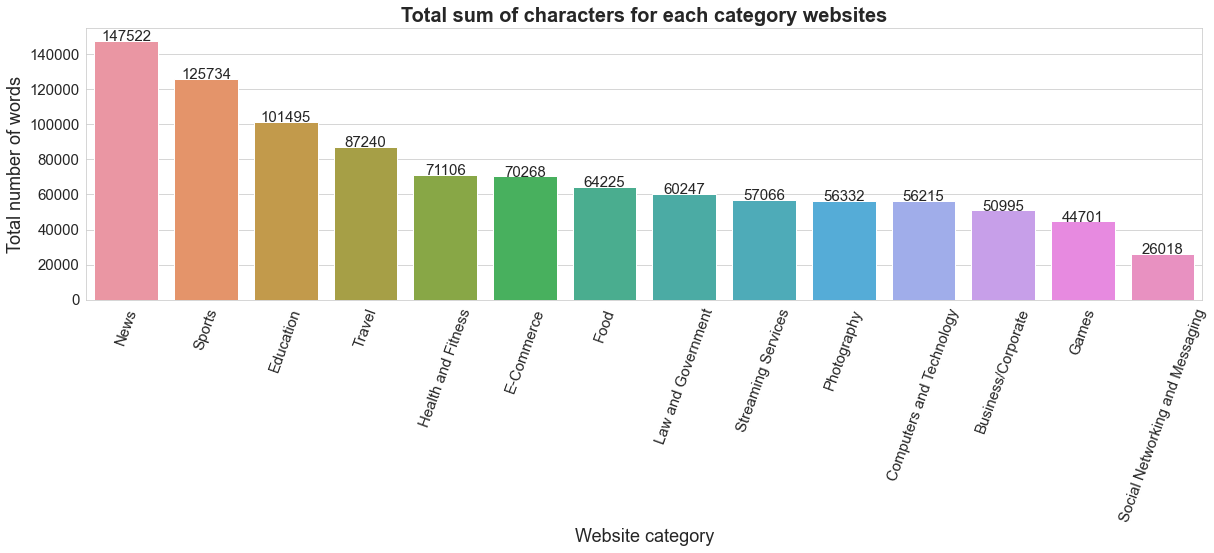

In [17]:
c1  = pd.Series(id_to_category).to_frame()
c2  = pd.Series(wordsum).to_frame()
tbl = pd.concat([c1,c2],axis=1,ignore_index=True)
tbl.columns=['Website category','Total number of words']
tbl_sorted = tbl.sort_values(by='Total number of words',ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
bar = sns.barplot(x='Website category',y='Total number of words',data=tbl_sorted)
for rect in bar.patches:
    bar.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75, '%d' % rect.get_height(), horizontalalignment='center', fontsize = 15)
bar.set_xlabel('Website category', fontsize=18)
bar.set_ylabel('Total number of words', fontsize=18)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total sum of characters for each category websites',fontweight='bold',fontsize=20)

### WordCloud

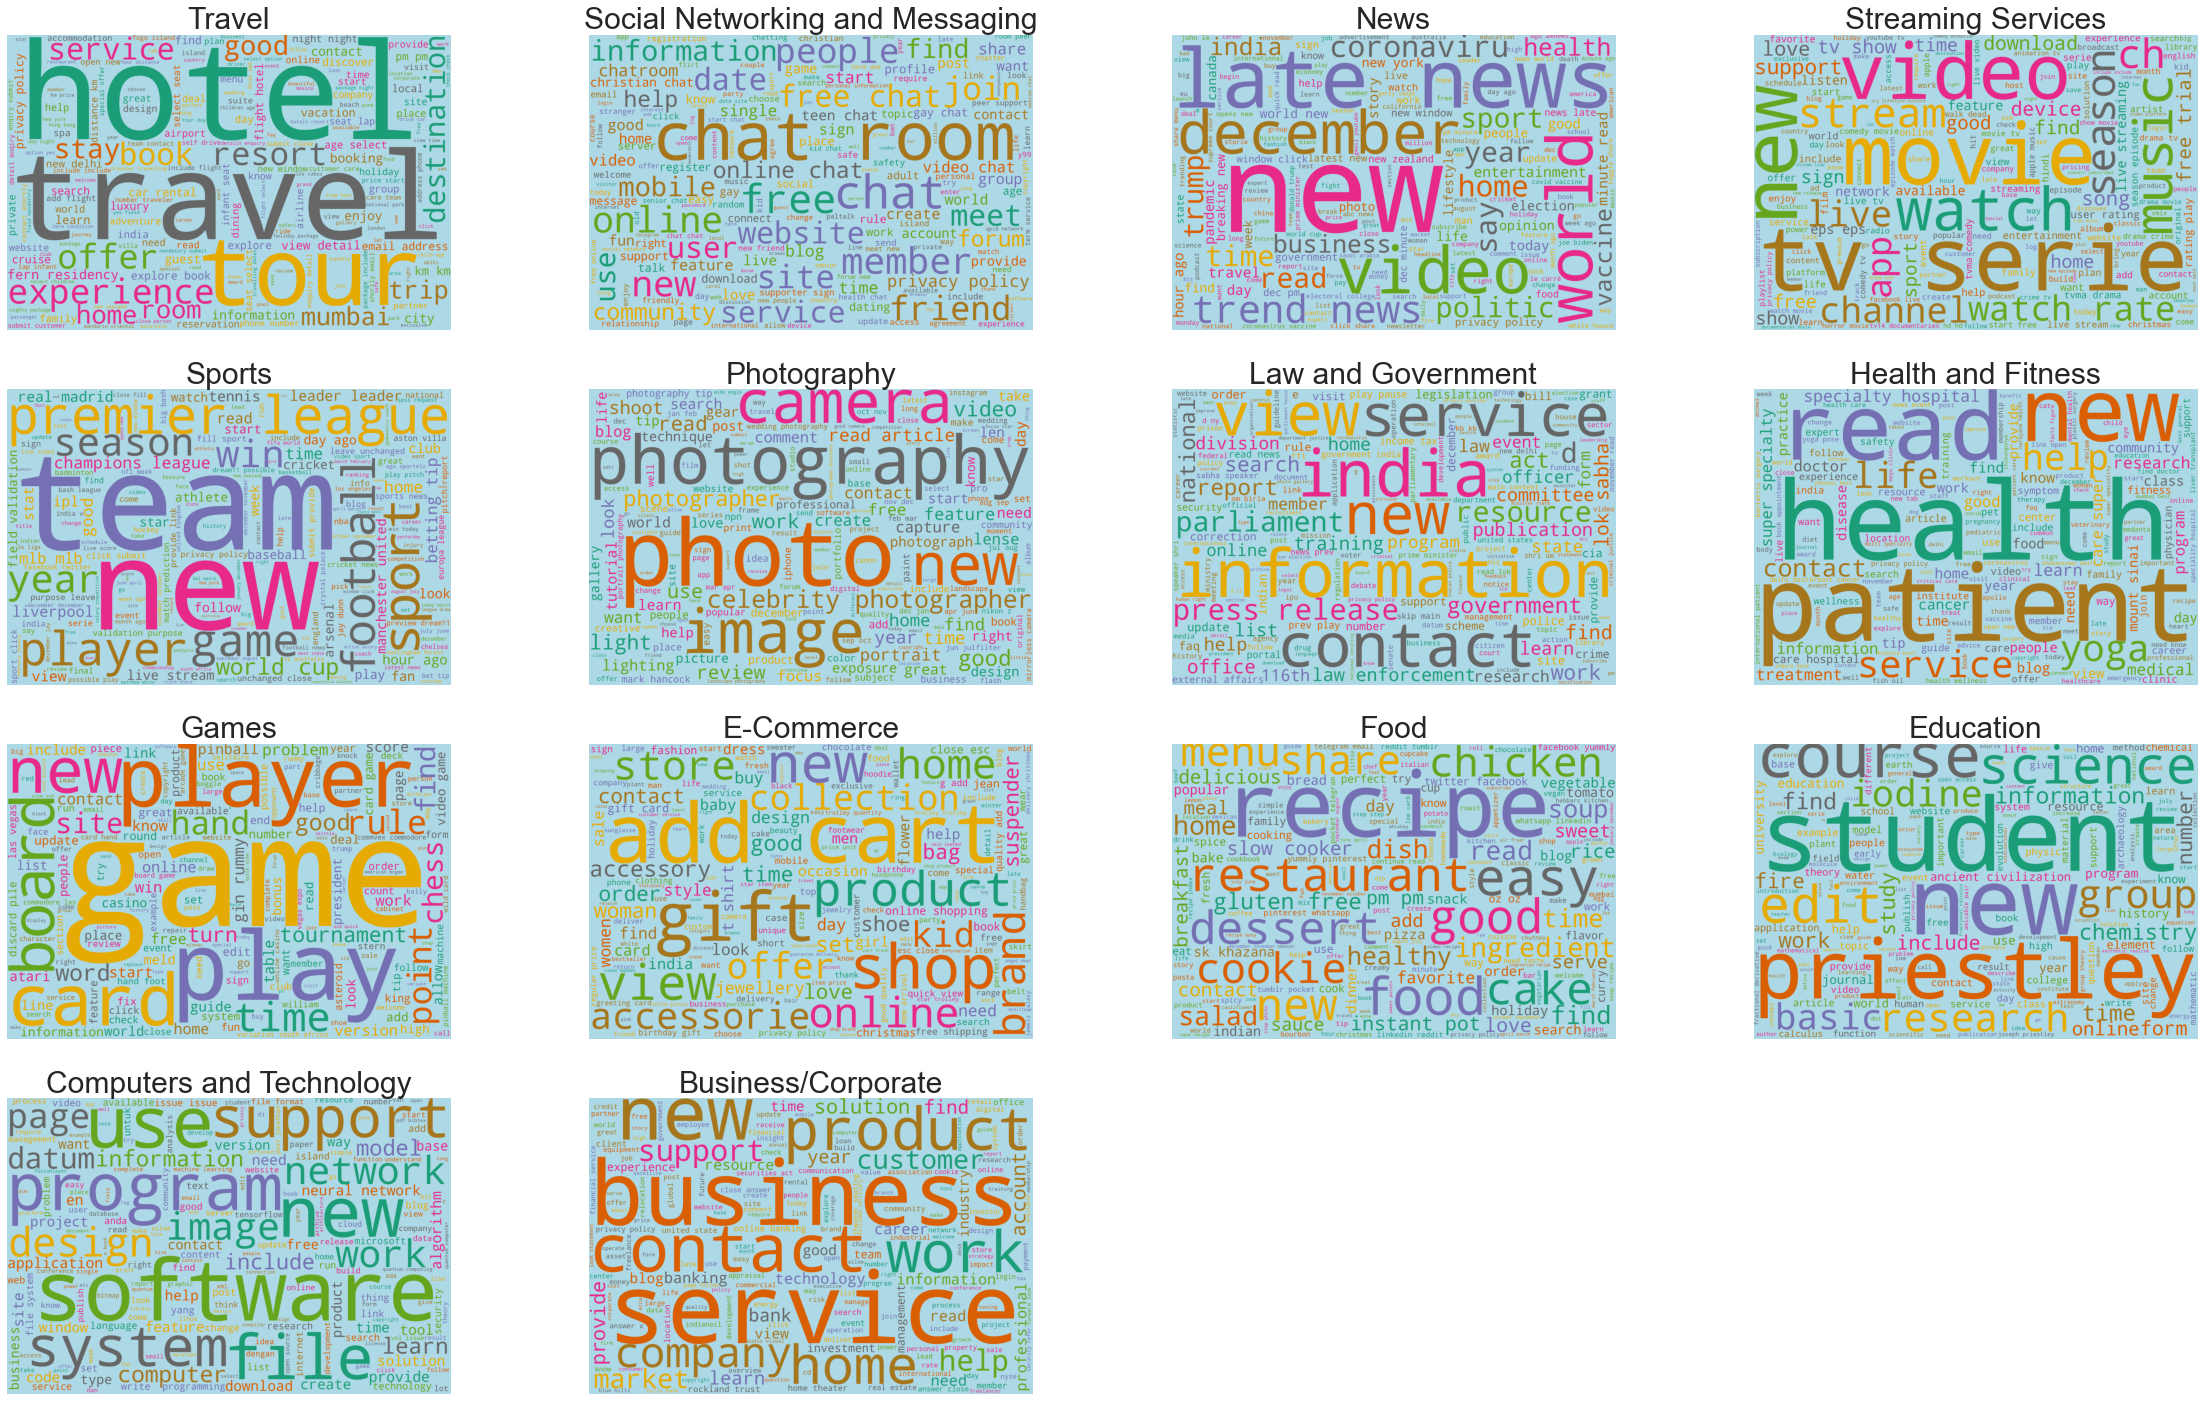

In [18]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
for c in id_to_category:
    one_category_set = wbs_df[wbs_df['Category']==id_to_category[c]] 
    category_text = one_category_set.cleaned_website_text.values
    cloudtext=WordCloud(stopwords=STOPWORDS,colormap="Dark2",background_color='lightblue',collocations=True, width=2400, height=1600).generate(" ".join(category_text))    
    plt.subplot(4,4,c+1)
    plt.title(id_to_category[c],fontsize=30)
    plt.axis('off')
    plt.imshow(cloudtext)

In [19]:
wbs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 1391
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1376 non-null   object
 1   cleaned_website_text  1376 non-null   object
 2   Category              1376 non-null   object
 3   CategoryID            1376 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 86.0+ KB


### Lemmatization (Use spaCy with lower case conversion, STOP_WORDS. Punctuation removal)

In [20]:
#from nltk.stem.wordnet import WordNetLemmatizer
import spacy
nlp= spacy.load('en_core_web_sm')
def lemmaprocess(text):
    lower= text.lower()
    document= nlp(lower)
    tokens= [token.lemma_ for token in document ]
    token_lemma= [lemma for lemma in tokens if lemma not in spacy.lang.en.stop_words.STOP_WORDS and lemma.isalpha()]
    return " ".join(token_lemma)

### Perform lemmatization

In [21]:
wbs_df['cleaned_website_text_lemm'] = wbs_df['cleaned_website_text'].apply(lemmaprocess)
wbs_df[['cleaned_website_text_lemm', 'cleaned_website_text']]

,cleaned_website_text_lemm,cleaned_website_text
0,official site good hotel accommodation big sav...,official site good hotel accommodation big sav...
1,expedia hotel book site like use vacation work...,expedia hotel book sites like use vacation wor...
2,tripadvisor hotel book site like previously de...,tripadvisor hotel book sites like previously d...
3,cheap flight search compare flight momondo fin...,cheap flights search compare flights momondo f...
4,bot create free account create free account si...,bot create free account create free account si...
...,...,...
1387,electroshop home theater decor interior seat s...,electroshops home theater decor interiors seat...
1388,clean ridge soap company clean ridge soap comp...,clean ridge soap company clean ridge soap comp...
1389,home page pet craft exquisitely piece handcut ...,home page pet crafts exquisitely piece handcut...
1390,home theater marketplace home theater seating ...,home theater marketplace home theater seating ...


### CountVectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=2, max_features=200000, 
                             strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                             ngram_range=(1,3), stop_words='english')
train_matrix_cntvec = count_vect.fit_transform(wbs_df['cleaned_website_text_lemm']).toarray()
print("There are %d text, each text is represented by %d features (TF-IDF score of unigrams, bigrams)" %(train_matrix_cntvec.shape))

There are 1376 text, each text is represented by 130375 features (TF-IDF score of unigrams, bigrams)


### Train Test Split from CountVectorizer train matrix

In [23]:
from sklearn.model_selection import train_test_split

# split data 
X_train_cntvec, X_test_cntvec, Y_train_cntvec, Y_test_cntvec = train_test_split(train_matrix_cntvec, wbs_df['Category'], test_size=0.25, random_state=5)

In [24]:
X_train_cntvec

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
Y_train_cntvec.value_counts()

Education                          91
Streaming Services                 83
Travel                             83
E-Commerce                         81
Sports                             79
Business/Corporate                 73
Health and Fitness                 73
Food                               71
Games                              70
Social Networking and Messaging    69
Computers and Technology           68
Photography                        67
News                               66
Law and Government                 58
Name: Category, dtype: int64

In [26]:
Y_test_cntvec.value_counts()

Business/Corporate                 36
News                               30
Games                              28
Photography                        26
Law and Government                 26
Computers and Technology           25
Sports                             25
Travel                             24
Education                          23
Health and Fitness                 23
Streaming Services                 22
E-Commerce                         21
Food                               21
Social Networking and Messaging    14
Name: Category, dtype: int64

### TfidfVectorizer

In [27]:
### Create TfidfVectorizer.

#help(TfidfVectorizer)

tfv = TfidfVectorizer(min_df=2,  max_features=150000, sublinear_tf=False,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

#Construct the required TF-IDF matrix by fitting and transforming the data
train_matrix_tfidfvec = tfv.fit_transform(wbs_df['cleaned_website_text_lemm']).toarray()
print("There are %d text, each text is represented by %d features (TF-IDF score of unigrams, bigrams)" %(train_matrix_tfidfvec.shape))

There are 1376 text, each text is represented by 130375 features (TF-IDF score of unigrams, bigrams)


### Train Test Split from TfidfVectorizer train matrix

In [28]:
from sklearn.model_selection import train_test_split

# split data 
X_train_tfidfvec, X_test_tfidfvec, Y_train_tfidfvec, Y_test_tfidfvec = train_test_split(train_matrix_tfidfvec, wbs_df['Category'], test_size=0.25, random_state=5)

In [29]:
X_train_tfidfvec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
Y_train_tfidfvec.value_counts()

Education                          91
Streaming Services                 83
Travel                             83
E-Commerce                         81
Sports                             79
Business/Corporate                 73
Health and Fitness                 73
Food                               71
Games                              70
Social Networking and Messaging    69
Computers and Technology           68
Photography                        67
News                               66
Law and Government                 58
Name: Category, dtype: int64

In [31]:
Y_test_tfidfvec.value_counts()

Business/Corporate                 36
News                               30
Games                              28
Photography                        26
Law and Government                 26
Computers and Technology           25
Sports                             25
Travel                             24
Education                          23
Health and Fitness                 23
Streaming Services                 22
E-Commerce                         21
Food                               21
Social Networking and Messaging    14
Name: Category, dtype: int64

###
### Multinomial Naive Bayes (Using CountVectorizer)

In [32]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train_cntvec, Y_train_cntvec)

MultinomialNB()

### Accuracy for MNB:

In [33]:
predictions_mnb = MNB.predict(X_test_cntvec)
accuracy_score_mnb = metrics.accuracy_score(predictions_mnb, Y_test_cntvec)
print(str('MNB accuracy : '+'{:04.2f}'.format(accuracy_score_mnb*100))+'%')

MNB accuracy : 90.12%


### Cross Validation Score for MNB:

In [34]:
### Cross Validation - will perform prediction and evaluation
## to obtain average scoring from partitioned training and testing datasets.

### using only the fitted training data
scores_mnb = cross_val_score(MNB, X_train_cntvec, Y_train_cntvec, cv=5)
print('MNB Cross Valuation Score :','{:04.4f}'.format(np.mean(scores_mnb)), scores_mnb)

MNB Cross Valuation Score : 0.8750 [0.87439614 0.87922705 0.87864078 0.87378641 0.86893204]


### Precision, Recall, F1-score and Clasification Matrix for MNB:
Precision_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Recall_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

F1 Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [35]:
### Precision, Recall and F1 Score

precisions_mnb = precision_score(Y_test_cntvec, predictions_mnb, average=None)
recalls_mnb = recall_score(Y_test_cntvec, predictions_mnb, average=None)
f1s_mnb = f1_score(Y_test_cntvec, predictions_mnb, average=None)
print('MNB-Precision(mean) :', '{:04.4f}'.format(np.mean(precisions_mnb)),
      '  MNB-Recall(mean) :', '{:04.4f}'.format(np.mean(recalls_mnb)),
      '  MNB-F1_sore(mean) :', '{:04.4f}'.format(np.mean(f1s_mnb)))
#print('MNB Precision', np.mean(precisions_mnb), precisions_mnb)

MNB-Precision(mean) : 0.9138   MNB-Recall(mean) : 0.8986   MNB-F1_sore(mean) : 0.9008


In [36]:
print('\t\t\t\tCLASSIFICATIION METRICS - MultinomialNB\n')
#print(classification_report(predictions_mnb,Y_test))
print(classification_report(predictions_mnb, Y_test_cntvec, target_names= wbs_df['Category'].unique()))

				CLASSIFICATIION METRICS - MultinomialNB

                                 precision    recall  f1-score   support

                         Travel       0.86      0.94      0.90        33
Social Networking and Messaging       0.76      0.95      0.84        20
                           News       1.00      0.91      0.95        23
             Streaming Services       1.00      0.79      0.88        29
                         Sports       0.90      0.95      0.93        20
                    Photography       0.82      0.92      0.87        25
             Law and Government       0.87      0.91      0.89        22
             Health and Fitness       1.00      1.00      1.00        26
                          Games       0.93      0.74      0.82        38
                     E-Commerce       0.85      1.00      0.92        22
                           Food       0.71      1.00      0.83        10
                      Education       0.96      0.89      0.92        27
     

### Confusion Matrix for MNB:

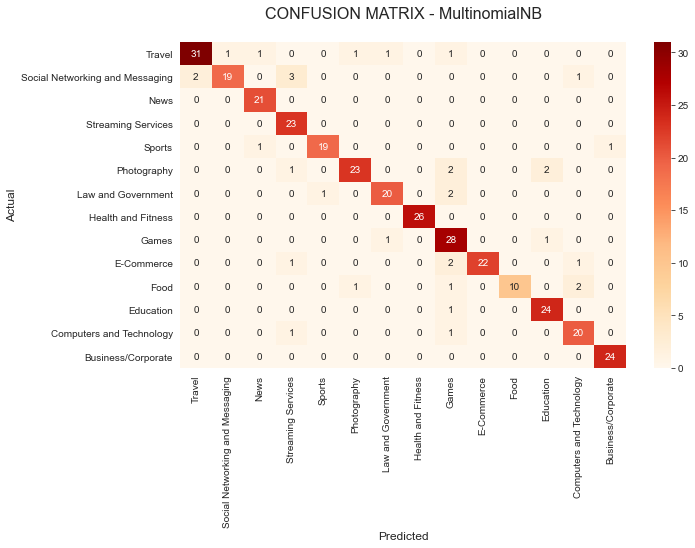

In [37]:
conf_mat_mnb = confusion_matrix(Y_test_cntvec, predictions_mnb)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_mnb, annot=True, cmap="OrRd", fmt='d', xticklabels=category_with_id_df.Category.values, yticklabels=category_with_id_df.Category.values)
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted', size=12)
plt.title("CONFUSION MATRIX - MultinomialNB\n", size=16);

###
### Gaussian Naive Bayes (Using CountVectorizer)

In [38]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(X_train_cntvec, Y_train_cntvec)

GaussianNB()

### Accuracy for GNB:

In [39]:
predictions_gnb = GNB.predict(X_test_cntvec)
accuracy_score_gnb = metrics.accuracy_score(predictions_gnb, Y_test_cntvec)
print(str('GNB accuracy : '+'{:04.2f}'.format(accuracy_score_gnb*100))+'%')

GNB accuracy : 76.45%


### Cross Validation Score for GNB:

In [40]:
### Cross Validation - will perform prediction and evaluation
## to obtain average scoring from partitioned training and testing datasets.

### using only the fitted training data
scores_gnb = cross_val_score(GNB, X_train_cntvec, Y_train_cntvec, cv=5)
print('GNB Cross Valuation Score :','{:04.4f}'.format(np.mean(scores_gnb)), scores_gnb)

GNB Cross Valuation Score : 0.7500 [0.74879227 0.7826087  0.76213592 0.70873786 0.74757282]


### Precision, Recall, F1-score and Clasification Matrix for GNB:

In [41]:
### Precision, Recall and F1 score

precisions_gnb = precision_score(Y_test_cntvec, predictions_gnb, average=None)
recalls_gnb = recall_score(Y_test_cntvec, predictions_gnb, average=None)
f1s_gnb = f1_score(Y_test_cntvec, predictions_gnb, average=None)
print('GNB-Precision(mean) :', '{:04.4f}'.format(np.mean(precisions_gnb)),
      '  GNB-Recall(mean) :', '{:04.4f}'.format(np.mean(recalls_gnb)),
      '  GNB-F1_sore(mean) :', '{:04.4f}'.format(np.mean(f1s_gnb)))

GNB-Precision(mean) : 0.8089   GNB-Recall(mean) : 0.7740   GNB-F1_sore(mean) : 0.7696


In [42]:
print('\t\t\t\tCLASSIFICATIION METRICS - GaussianNB\n')
print(classification_report(predictions_gnb, Y_test_cntvec, target_names= wbs_df['Category'].unique()))

				CLASSIFICATIION METRICS - GaussianNB

                                 precision    recall  f1-score   support

                         Travel       0.53      0.86      0.66        22
Social Networking and Messaging       0.52      1.00      0.68        13
                           News       1.00      0.72      0.84        29
             Streaming Services       0.96      0.58      0.72        38
                         Sports       0.67      0.93      0.78        15
                    Photography       0.71      0.87      0.78        23
             Law and Government       0.83      0.83      0.83        23
             Health and Fitness       0.77      0.91      0.83        22
                          Games       0.87      0.54      0.67        48
                     E-Commerce       0.58      0.83      0.68        18
                           Food       0.71      0.91      0.80        11
                      Education       0.88      0.76      0.81        29
       C

### Confusion Matrix for GNB:

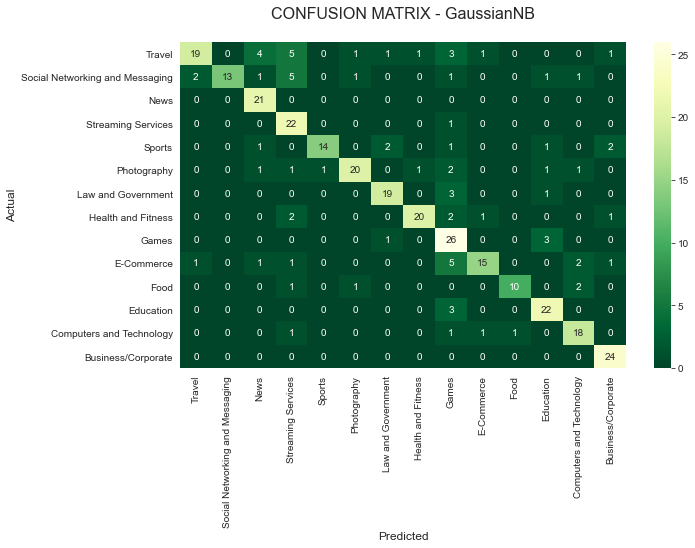

In [43]:
conf_mat_gnb = confusion_matrix(Y_test_cntvec, predictions_gnb)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_gnb, annot=True, cmap="YlGn_r", fmt='d', xticklabels=category_with_id_df.Category.values, yticklabels=category_with_id_df.Category.values)
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted', size=12)
plt.title("CONFUSION MATRIX - GaussianNB\n", size=16);

###
### LinearSVC (Using TFIDF Vectorizer)

In [44]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()
LSVC.fit(X_train_tfidfvec, Y_train_tfidfvec)

LinearSVC()

### Accuracy for LinearSVC:

In [45]:
predictions_lsvc = LSVC.predict(X_test_tfidfvec)
accuracy_score_lsvc = metrics.accuracy_score(predictions_lsvc, Y_test_tfidfvec)
print(str('LinearSVC accuracy : '+'{:04.2f}'.format(accuracy_score_lsvc*100))+'%')

LinearSVC accuracy : 94.48%


### Cross Validation Score for LinearSVC:

In [46]:
### Cross Validation - will perform prediction and evaluation
## to obtain average scoring from partitioned training and testing datasets.

### using only the fitted training data
scores_lsvc = cross_val_score(LSVC, X_train_tfidfvec, Y_train_tfidfvec, cv=5)
print('LinearSVC Cross Valuation Score :','{:04.4f}'.format(np.mean(scores_lsvc)), scores_lsvc)

LinearSVC Cross Valuation Score : 0.9244 [0.9178744  0.93719807 0.94660194 0.91747573 0.90291262]


### Precision, Recall, F1-score and Clasification Matrix for LinearSVC:

In [47]:
### Precision, Recall and F1 score

precisions_lsvc = precision_score(Y_test_tfidfvec, predictions_lsvc, average=None)
recalls_lsvc = recall_score(Y_test_tfidfvec, predictions_lsvc, average=None)
f1s_lsvc = f1_score(Y_test_tfidfvec, predictions_lsvc, average=None)
print('LinearSVC-Precision(mean) :', '{:04.4f}'.format(np.mean(precisions_lsvc)),
      '  LinearSVC-Recall(mean) :', '{:04.4f}'.format(np.mean(recalls_lsvc)),
      '  LinearSVC-F1_sore(mean) :', '{:04.4f}'.format(np.mean(f1s_lsvc)))

LinearSVC-Precision(mean) : 0.9450   LinearSVC-Recall(mean) : 0.9429   LinearSVC-F1_sore(mean) : 0.9430


In [48]:
print('\t\t\t\tCLASSIFICATIION METRICS - LinearSVC\n')
print(classification_report(predictions_lsvc, Y_test_tfidfvec, target_names= wbs_df['Category'].unique()))

				CLASSIFICATIION METRICS - LinearSVC

                                 precision    recall  f1-score   support

                         Travel       0.86      0.97      0.91        32
Social Networking and Messaging       0.92      0.88      0.90        26
                           News       1.00      0.95      0.98        22
             Streaming Services       1.00      0.92      0.96        25
                         Sports       0.95      1.00      0.98        20
                    Photography       0.96      0.96      0.96        28
             Law and Government       0.87      0.91      0.89        22
             Health and Fitness       1.00      1.00      1.00        26
                          Games       0.93      0.88      0.90        32
                     E-Commerce       1.00      1.00      1.00        26
                           Food       0.79      0.92      0.85        12
                      Education       0.96      0.92      0.94        26
       Co

### Confusion Matrix for LinearSVC:

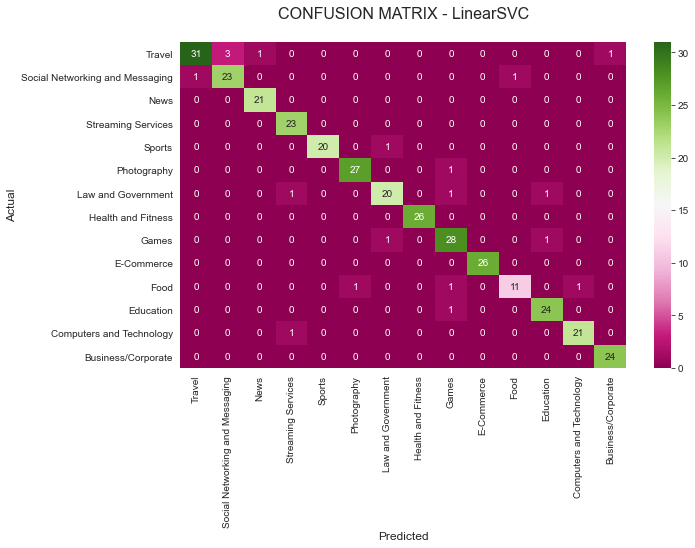

In [49]:
conf_mat_lsvc = confusion_matrix(Y_test_tfidfvec, predictions_lsvc)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_lsvc, annot=True, cmap="PiYG", fmt='d', xticklabels=category_with_id_df.Category.values, yticklabels=category_with_id_df.Category.values)
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted', size=12)
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

###
### Random Forest Classifier (Using CountVectorizer)

In [50]:
from sklearn.ensemble import RandomForestClassifier

RFC=RandomForestClassifier()
RFC.fit(X_train_tfidfvec, Y_train_tfidfvec)

RandomForestClassifier()

### Accuracy for RFC:

In [51]:
predictions_rfc=RFC.predict(X_test_tfidfvec)
accuracy_score_rfc = metrics.accuracy_score(predictions_rfc, Y_test_tfidfvec)
print(str('RFC accuracy : '+'{:04.2f}'.format(accuracy_score_rfc*100))+'%')

RFC accuracy : 81.40%


### Cross Validation Score for RFC:

In [52]:
### Cross Validation - will perform prediction and evaluation
## to obtain average scoring from partitioned training and testing datasets.

### using only the fitted training data
scores_rfc = cross_val_score(RFC, X_train_tfidfvec, Y_train_tfidfvec, cv=5)
print('RFC Cross Valuation Score :','{:04.4f}'.format(np.mean(scores_rfc)), scores_rfc)

RFC Cross Valuation Score : 0.8372 [0.83574879 0.83091787 0.84466019 0.83495146 0.83980583]


### Precision, Recall, F1-score and Clasification Matrix for RFC:

In [53]:
### Precision, Recall and F1 score

precisions_rfc = precision_score(Y_test_tfidfvec, predictions_rfc, average=None)
recalls_rfc = recall_score(Y_test_tfidfvec, predictions_rfc, average=None)
f1s_rfc = f1_score(Y_test_tfidfvec, predictions_rfc, average=None)
print('RFC-Precision(mean) :', '{:04.4f}'.format(np.mean(precisions_rfc)),
      '  RFC-Recall(mean) :', '{:04.4f}'.format(np.mean(recalls_rfc)),
      '  RFC-F1_sore(mean) :', '{:04.4f}'.format(np.mean(f1s_rfc)))

RFC-Precision(mean) : 0.8557   RFC-Recall(mean) : 0.8218   RFC-F1_sore(mean) : 0.8244


In [54]:
print('\t\t\t\tCLASSIFICATIION METRICS - RFC\n')
print(classification_report(predictions_rfc, Y_test_tfidfvec, target_names= wbs_df['Category'].unique()))

				CLASSIFICATIION METRICS - RFC

                                 precision    recall  f1-score   support

                         Travel       0.58      0.88      0.70        24
Social Networking and Messaging       0.56      0.82      0.67        17
                           News       0.86      0.82      0.84        22
             Streaming Services       0.96      0.85      0.90        26
                         Sports       0.95      0.83      0.89        24
                    Photography       0.75      0.95      0.84        22
             Law and Government       0.74      0.89      0.81        19
             Health and Fitness       1.00      1.00      1.00        26
                          Games       0.73      0.85      0.79        26
                     E-Commerce       0.96      0.45      0.62        55
                           Food       0.71      1.00      0.83        10
                      Education       0.88      0.81      0.85        27
       Computer

### Confusion Matrix for RFC:

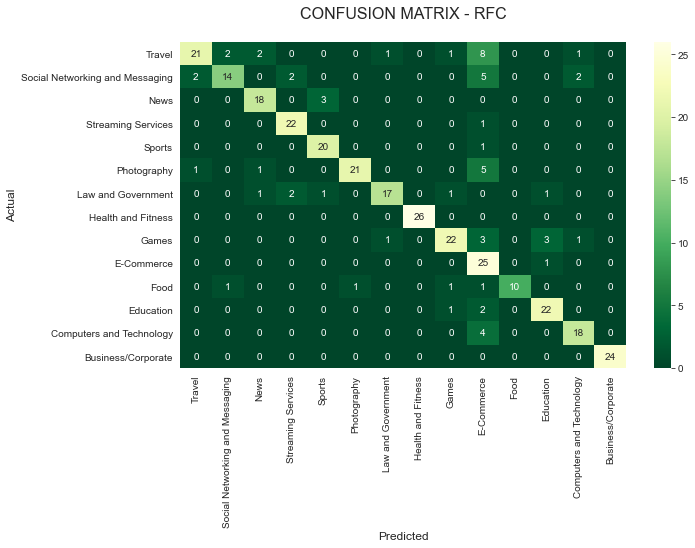

In [55]:
conf_mat_rfc = confusion_matrix(Y_test_tfidfvec, predictions_rfc)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_rfc, annot=True, cmap="YlGn_r", fmt='d', xticklabels=category_with_id_df.Category.values, yticklabels=category_with_id_df.Category.values)
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted', size=12)
plt.title("CONFUSION MATRIX - RFC\n", size=16);

###
### Support Vector Machine (SVC) (Using TFIDF Vectorizer)

In [56]:
from sklearn.svm import SVC

SVC=SVC()
SVC.fit(X_train_tfidfvec, Y_train_tfidfvec)

SVC()

### Accuracy for SVC:

In [57]:
predictions_svc=SVC.predict(X_test_tfidfvec)
accuracy_score_svc = metrics.accuracy_score(predictions_svc, Y_test_tfidfvec)
print(str('SVC accuracy : '+'{:04.2f}'.format(accuracy_score_svc*100))+'%')

SVC accuracy : 87.50%


### Cross Validation Score for SVC:

In [58]:
### Cross Validation - will perform prediction and evaluation
## to obtain average scoring from partitioned training and testing datasets.

### using only the fitted training data
scores_svc = cross_val_score(SVC, X_train_tfidfvec, Y_train_tfidfvec, cv=5)
print('SVC Cross Valuation Score :','{:04.4f}'.format(np.mean(scores_svc)), scores_svc)

SVC Cross Valuation Score : 0.8576 [0.81642512 0.85990338 0.89320388 0.84951456 0.86893204]


### Precision, Recall, F1-score and Clasification Matrix for SVC:

In [59]:
### Precision, Recall and F1 score

precisions_svc = precision_score(Y_test_tfidfvec, predictions_svc, average=None)
recalls_svc = recall_score(Y_test_tfidfvec, predictions_svc, average=None)
f1s_svc = f1_score(Y_test_tfidfvec, predictions_svc, average=None)
print('SVC-Precision(mean) :', '{:04.4f}'.format(np.mean(precisions_svc)),
      '  SVC-Recall(mean) :', '{:04.4f}'.format(np.mean(recalls_svc)),
      '  SVC-F1_sore(mean) :', '{:04.4f}'.format(np.mean(f1s_svc)))

SVC-Precision(mean) : 0.9100   SVC-Recall(mean) : 0.8739   SVC-F1_sore(mean) : 0.8821


In [60]:
print('\t\t\t\tCLASSIFICATIION METRICS - LinearSVC\n')
print(classification_report(predictions_svc, Y_test_tfidfvec, target_names= wbs_df['Category'].unique()))

				CLASSIFICATIION METRICS - LinearSVC

                                 precision    recall  f1-score   support

                         Travel       0.86      0.84      0.85        37
Social Networking and Messaging       0.76      0.86      0.81        22
                           News       0.95      0.95      0.95        21
             Streaming Services       1.00      0.50      0.67        46
                         Sports       0.90      1.00      0.95        19
                    Photography       0.82      0.96      0.88        24
             Law and Government       0.83      0.95      0.88        20
             Health and Fitness       0.85      1.00      0.92        22
                          Games       0.87      0.93      0.90        28
                     E-Commerce       0.81      0.95      0.88        22
                           Food       0.71      1.00      0.83        10
                      Education       0.92      0.96      0.94        24
       Co

### Confusion Matrix for SVC:

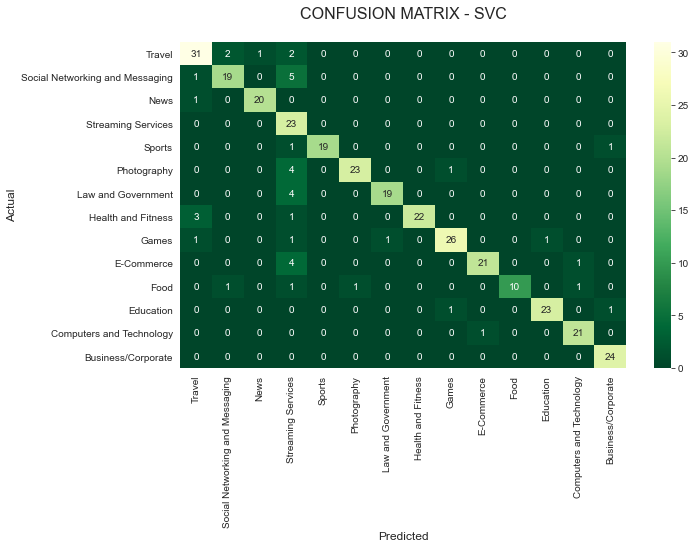

In [61]:
conf_mat_svc = confusion_matrix(Y_test_tfidfvec, predictions_svc)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_svc, annot=True, cmap="YlGn_r", fmt='d', xticklabels=category_with_id_df.Category.values, yticklabels=category_with_id_df.Category.values)
plt.ylabel('Actual', size=12)
plt.xlabel('Predicted', size=12)
plt.title("CONFUSION MATRIX - SVC\n", size=16);

###
### Prediction Outcome of the Classifiers (MNB, GNB, SVC, LinearSVC, RFC)

In [62]:
def predMNB(msg): 
    msg = tfv.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = MNB.predict(msg)
    return prediction[0]

def predGNB(msg): 
    msg = tfv.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = GNB.predict(msg)
    return prediction[0]

def predSVC(msg): 
    msg = tfv.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = SVC.predict(msg)
    return prediction[0]

def predLSVC(msg): 
    msg = tfv.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = LSVC.predict(msg)
    return prediction[0]

def predRFC(msg): 
    msg = tfv.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = RFC.predict(msg)
    return prediction[0]

In [66]:
travel            = "It all begins and ends with money. Once you’ve set your mind to travelling for a year, or indefinitely, it’s high time to start saving up – unless, of course, you’ve already been doing that. How much money do you need? That depends on the duration of your trip and what you want to do and see. It also depends on your preferred travelling style – is it backpacking, hitchhiking/using public transport and sleeping in hostels or do you feel more comfortable staying at boutique hotels and going on organised trips? The difference between the budgets of the above travelling styles can be quite significant. It also depends on whether you’re going to spend most of your trip in countries with a high economic standard (e.g. the USA, Australia, the Baltic states) where the prices are several times higher than the ones in Southeast Asia and some South American countries. Once you’ve decided on which style of travelling you prefer and which countries/continent you’d like to visit, you can look up a lot of information online; it should be fairly obvious that one thousand euros per month should more than suffice for a low-budget backpacking in Southeast Asia. Don’t forget to add the approximate price of the plane tickets, insurance, visas etc. to the amount of money you’ll be needing, though. TIP: If you want to go really low-budget, there are many places around the world where you can volunteer (in exchange for food and accommodation), “look after” the house and pets, or find temporary work in the tourism or agricultural sector (hostels, cafés, fruit picking, helping out on an organic farm...). In such cases, you can set out with a minimum amount of money you’ve saved up, plus you’ll be having an unforgettable experience"
space_travel      = "Richard Branson became the first person to ride into space aboard a rocket he helped fund. The supersonic space plane developed by his company, Virgin Galactic, roared into the sky over New Mexico early Sunday, carrying Branson and three fellow crewmembers. Branson -— along with Virgin Galactic employees Beth Moses, Colin Bennett, and Sirisha Bandla and pilots Dave Mackay and Michael Masucci — boarded the SpaceShipTwo, a winged plane with a single rocket motor that the company has spent nearly two decades developing, before the crack of dawn. Attached beneath its massive, twin-fuselaged mothership, dubbed WhiteKnightTwo, the vehicle took to the skies at 8:30 am MT and climbed to about 50,000 feet in the air. Just after 9:15 in the morning, the SpaceShipTwo detached from its mothership and dropped momentarily before its engine screamed to life and the vehicle swooped upward. On board, the passengers experienced up to three Gs of force from the burst of extreme acceleration and watched the blue sky fade into the star-speckled darkness of outer space. At the top of the flight path, more than 50 miles high, the vehicle was suspended in weightlessness for a few minutes, allowing the passengers to enjoy panoramic views of the Earth and space as SpaceShipTwo flipped onto its belly. It then deployed its feathering system, which curls the plane's wings upward, mimicking the shape of a badminton shuttlecock, to turn the spaceship rightward as it flew back into the Earth's thick atmosphere and glided back down to a runway landing. Virgin Galactic spaceplane VSS Unity rockets to outer space, with Richard Branson and crew onboard. Virgin Galactic spaceplane VSS Unity rockets to outer space, with Richard Branson and crew onboard. As Branson floated around in microgravity, he taped a message using cameras onboard the space plane: To all you kids out there — I was once a child with a dream, looking up to the stars. Now I'm an adult in a spaceship...If we can do this, just imagine what you can do, he said. This flight marked only the fourth test flight of the vehicle that reached the edge of space. Surrounding SpaceShipTwos takeoff was — in typical Branson fashion -— a high-production party with friends, family, employees and a few VIPs in attendance. Earlier on Sunday, Branson tweeted a picture of himself and a barefoot Elon Musk hanging out. Grammy-nominated artist Khalid is also expected to perform an as-yet-unreleased song on an outdoor stage."
education         = "Temasek Polytechnic (Abbreviation: TP) is a post-secondary academic institution located in Tampines, Singapore. It is the third polytechnic established in the country. Temasek Polytechnic teaches an industry-focused curriculum, which is an alternative to a broader based junior college/ pre-university education. Polytechnic graduates in Singapore are sought after for entry level professional positions or well-prepared to complete university degrees. In contrast to polytechnics in the United States and the UK, polytechnics in Singapore admit the majority of their students after secondary school, mostly at the age of 16-17(before receiving high school education), which is after ten years of formal education. A Temasek Polytechnic diploma in a specialised area of study, for example Law & Management, is awarded after completing three years of academic studies and a industry internship. Established on April 6, 1990, the campus of the institute sits on a 30 hectare plot near the Bedok Reservoir in the eastern part of Singapore. Temasek Polytechnic features 37 full-time and > 40 part-time diploma courses, spread over 6 academic schools. Currently, Temasek Polytechnic has approximately 14,000 full-time students and more than 1,200 academic staff."
social_messaging  = "1 – Facebook fb This is easily the largest social networking site in the world and one of the most widely used. And, Facebook was perhaps the first that surpassed the landmark of 1 billion user accounts. Apart from the ability to network with friends and relatives, you can also access different Facebook apps to sell online and you can even market or promote your business, brand and products by using paid Facebook ads. Recently Facebook has lost the trust of millions of its users by allowing 3rd parties to access over 87 million users’ personal data. This is a massive breech of trust and has created a feeling of unrest amongst the social media platform’s audience. So much so that there is now a #deletefacebook campaign where people are completely removing themselves from Facebook and using other networks instead. If you’re concerned about what Facebook is doing with your data, then why not check out my guide on alternatives to Facebook, and see if there’s a better place for you to interact with family and friends. Number of active users per month: 1.59 billion approximately 2 – WhatsApp WhatsApp Despite having been acquired by Facebook in 2014, this instant messaging platform exists as an independent entity. It arrived on the scene much later than Facebook, but has been able to capture the imagination of millions of people across the world by giving them the ability to communicate and share instantly with individuals and groups. The WhatsApp call feature is just the icing on the cake! Number of active users per month: 1 billion approximately 3- QQ qq Tencent QQ (more popularly known as QQ) is an instant messaging (chat-based) social media platform. It became international (with more than 80 countries using it), after it was launched in China. It can be used to stay in touch with friends through texts, video calls and voice chats. It even has a built-in translator to translate your chats. To find out more, head over to our Chinese Social Media stats page. Number of active users per month: 853 million approximately 4 – WeChat wechat This is an all-in-one communications app for messaging and calling (similar to WhatsApp) that enables you to connect with the people of your choice. It was also developed by Tencent in China and can easily work alongside QQ. As per the BI intelligence report, the number of WeChat users are fast catching up with the number of WhatsApp users. Related article: WeChat keyboard shortcuts Number of active users per month: 697 million approximately 5 – QZone Qzone Like QQ and WeChat, QZone is yet another social networking service developed by Tencent. It enables you to share photos, watch videos, listen to songs, write blogs, maintain diaries and so on. It also empowers you to choose the accessories and customize the look and feel of your QZone webpages. Number of active users per month: 640 million approximately 6 – Tumblr tumblr Having been owned by Yahoo since 2013, Tumblr serves as a social media / micro blogging platform that can be used to find and follow things that you like. You can also use it to post anything, including multimedia, to a short-form blog. Moreover, it gives you the flexibility to customize almost everything. Number of active users per month: 555 million approximately 7 – Instagram instagram Instagram was launched as a unique social networking platform that was completely based on sharing photos and videos. This photo sharing social networking app thus enables you to capture the best moments of your life, with your phone’s camera or any other camera, and convert them into works of art. This is possible because Instagram allows you to apply multiple filters to your photos and you can easily post them to other popular social networking sites, such as Facebook and Twitter. It is now part of the Facebook empire. Learn how to grow your Instagram audience. Read more on Instagram Tools to help you increase social engagement and audience numbers. Number of active users per month: 400 million approximately 8 – Twitter twitter This social networking site enables you to post short text messages (called tweets), containing a limited number of characters (up to 280), to convey your message to the world. With the growing craze for online shopping, Twitter also makes it possible to promote your businesses and even shop directly through tweets. Learn how to create the perfect Twitter profile. Number of active users per month: 320 million approximately 9 – Google+ ( No Longer Available ) g+ Owned by the tech giant Alphabet (Google), this interest-based social networking platform enables you to stay in touch with people by sharing messages, photos, videos, useful links to sites and so on. It also extends support for video conferencing through Hangouts and allows businesses to promote their brands and products through Google+ business pages. Number of active users: 300 million approximately 10 – Baidu Tieba Baidu-Logo Offered by Baidu of China, a search engine company, Baidu Tieba (known as Postbar internationally) is a social forum network based on the keyword searches in the Baidu search engine. This discussion forum works on the unique concept of allowing you to create a social network group for a specific topic, using the search, or even to join an existing online social group. Number of active users per month: 300 million approximately 11 – Skype skype Skype, owned by Microsoft, is one of the most popular communication-based social networking platforms. It allows you to connect with people through voice calls, video calls (using a webcam) and text messaging. You can even conduct group conference calls. And, the best part is that Skype-to-Skype calls are free and can be used to communicate with anyone, located in any part of the world, over the internet. Number of active users per month: 300 million approximately"
health            = "Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy. Sometimes your body doesn’t make enough—or any—insulin or doesn’t use insulin well. Glucose then stays in your blood and doesn’t reach your cells. Over time, having too much glucose in your blood can cause health problems. Although diabetes has no cure, you can take steps to manage your diabetes and stay healthy. Sometimes people call diabetes “a touch of sugar” or “borderline diabetes.” These terms suggest that someone doesn’t really have diabetes or has a less serious case, but every case of diabetes is serious."
sport             = "The 2020 UEFA European Football Championship, commonly referred to as UEFA Euro 2020, or simply Euro 2020, is the 16th UEFA European Championship, the quadrennial international men's football championship of Europe organised by the Union of European Football Associations (UEFA).[1] The tournament, being held in 11 cities in 11 UEFA countries, was originally scheduled from 12 June to 12 July 2020, but was postponed due to the COVID-19 pandemic in Europe and rescheduled for 11 June to 11 July 2021.[2] It retains the name UEFA Euro 2020.[3] Portugal were the defending champions, having won the 2016 competition in France, but were eliminated in the round of 16 against Belgium.[4] The video assistant referee (VAR) system makes its debut at the European Championship in this tournament.[5] UEFA President Michel Platini said in 2012 that the tournament was to be hosted in several nations as a romantic one-off event to celebrate the 60th birthday of the European Championship competition.[6] Having the largest capacity of any of the stadiums entered for the competition, Wembley Stadium in London is scheduled to host the semi-finals and final for the second time, having done so before at the 1996 tournament in the stadium's former incarnation. The Stadio Olimpico in Rome was chosen to host the opening game, involving Turkey and host Italy. Originally to be played at 13 venues, two hosts were later removed: Brussels in December 2017 due to the abandonment of building the Eurostadium,[7] and Dublin in April 2021 as there was no guarantee that spectators could attend. Spain also changed their host city from Bilbao to Seville to allow an audience at matches"
sport2            = "On a night fraught with tension, Italy clinched its first major title for 15 years with a penalty shootout win over England in the Euro 2020 final. Luke Shaws goal inside the opening two minutes gave England a lead it looked like it would hold onto all night, before a goalmouth scramble midway through the second half allowed Leonardo Bonucci to poke home an equalizer for Italy. For the remainder of the match it felt as though extra-time and penalties were inevitable, as neither side seemed willing or brave enough to commit enough men forward to really trouble the opposing defenders. England had suffered innumerable heartbreaks on penalties over the years and this time it was Italy's turn to inflict yet more pain on beleaguered English fans as Marcus Rashford, Jadon Sancho and Bukayo Saka all missed from the spot. During the wild Italian celebrations, Bonucci -- who had been immense all night and rightly earned the man of the match award -- screamed it's coming to Rome into the pitch side camera to rub yet more salt into the wounds of English fans."
computer          = "Devices have been used to aid computation for thousands of years, probably initially in the form of a tally stick.[7] The Antikythera mechanism, dating from about the beginning of the first century BC, is generally considered to be the earliest known mechanical analog computer, and the earliest known geared mechanism.[8] Comparable geared devices did not emerge in Europe until the 16th century, and it was not until 1645 that the first mechanical calculator capable of performing the four basic arithmetical operations was developed.[9] Electronic computers, using either relays or valves, began to appear in the early 1940s. The electromechanical Zuse Z3, completed in 1941, was the world's first programmable computer, and by modern standards one of the first machines that could be considered a complete computing machine. During the Second World War, Colossus developed the first electronic digital computer to decrypt German messages. Although it was programmable, it was not general-purpose, being designed to perform only a single task. It also lacked the ability to store its program in memory; programming was carried out using plugs and switches to alter the internal wiring.[10] The first recognizably modern electronic digital stored-program computer was the Manchester Baby, which ran its first program on 21 June 1948.[11] The development of transistors in the late 1940s at Bell Laboratories allowed a new generation of computers to be designed with greatly reduced power consumption. The first commercially available stored-program computer, the Ferranti Mark I, contained 4050 valves and had a power consumption of 25 kilowatts. By comparison, the first transistorized computer developed at the University of Manchester and operational by November 1953, consumed only 150 watts in its final version.[12] Several other breakthroughs in semiconductor technology include the integrated circuit (IC) invented by Jack Kilby at Texas Instruments and Robert Noyce at Fairchild Semiconductor in 1959, the metal-oxide-semiconductor field-effect transistor (MOSFET) invented by Mohamed Atalla and Dawon Kahng at Bell Laboratories in 1959, and the microprocessor invented by Ted Hoff, Federico Faggin, Masatoshi Shima and Stanley Mazor at Intel in 1971. These important inventions led to the development of the personal computer (PC) in the 1970s, and the emergence of information and communications technology (ICT)"
photography       = "Master that dial on top of your camera and use Shutter Priority and Aperture Priority modes for amazing photography techniques. This is the perfect course if you own a digital SLR (DSLR), Mirrorless camera, or any digital camera with with a control dial on top. Learn not only why there are 2 Auto modes on almost all digital cameras, but why, when, and how to go beyond Auto mode! Stop-action, motion-blur, soft-focus backgrounds, and sharp depth-of-focus, are all covered in simple to understand lessons. Light, composition, proper camera and posing techniques, are all covered with examples and practice files."
singapore_makan   = "Steamed chicken served with rice cooked in chicken stock. This all-time favourite dish makes for a quick, fulfilling lunch. The quality of chicken stock is crucial to this dish, and you can tell by the steamed rice oozing with flavour and a fragrant aroma. Pour some dipping sauce over the chicken and give it a go. Hard-shell crabs cooked in semi-thick gravy with a tomato chilli base. The steamed crabs are partially cracked, then lightly stir-fried in a paste comprising of chilli sauce, ketchup and eggs. Despite its name, chilli crab is not all that spicy. Bread is normally ordered to soak up the gravy, so dig in with both hands!"
business_corp     = "SINGAPORE - Sembcorp Marine has proposed a further $1.5 billion rights issue to strengthen its financial position amid continued Covid-19 disruption, it said in a filing on the Singapore Exchange on Thursday (June 24). This will also help it accelerate towards renewable and clean energy, the firm said. It made the announcement on the same day it said it was signing an agreement with Keppel Corporation to explore a potential combination with Keppel Offshore and Marine. Sembcorp Marine president and chief executive Wong Weng Sun said: Since the last rights issue completed in September 2020, our operations have been severely impacted by the continuing Covid-19 disruptions. The liquidity from the proposed $1.5 billion rights issue will be vital in fortifying our financial position. It will ensure we emerge from this crisis as a strong and innovative player, with an increasing strategic focus on clean, sustainable and renewable energy solutions. Sembcorp Marine noted that the offshore and marine sector has experienced a prolonged and severe downturn since 2015. The onset of the Covid-19 pandemic in 2020 further delayed the industry recovery and created severe disruptions, including reductions in capital expenditure by oil majors and skilled manpower shortages, it said. It added that these disruptions have extended into 2021 with the reimposition of Covid-19 restrictions to combat new infections. Such disruptions to yard operations have affected the group's execution and completion of projects, along with deferrals of deliveries and payments by customers. The proposal to raise $1.5 billion is expected to be completed in the third quarter of this year.  It will be on the basis of three rights shares for every two existing shares held, at a rights issue price of eight cents per share, representing a discount of 35.7 per cent to the theoretical ex-rights price."


website_text = sport

In [67]:
print('Multinomial NB prediction              :', predMNB(website_text))
#print('Gaussian NB prediction                 :', predGNB(website_text))
print('LinearSVC prediction                   :', predLSVC(website_text))
print('Support Vector Machine(SVC) prediction :', predSVC(website_text))
#print('Random Forest Classifier prediction    :', predRFC(website_text))

Multinomial NB prediction              : Sports
LinearSVC prediction                   : Sports
Support Vector Machine(SVC) prediction : Sports


###
### Grid Search

In [65]:

# example of grid searching key hyperparametres for SVC
#from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
# define dataset
#X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define model and parameters
model = LinearSVC()
penalty = ['l1','l2']
loss = ['hinge','squared_hinge']
C = [50, 10, 1.0, 0.1, 0.01]     
multi_class = ['ovr', 'crammer_singer']
class_weight = ['None','balanced']
# define grid search
grid = dict(penalty=penalty, loss=loss, C=C, multi_class=multi_class, class_weight=class_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_tfidfvec, Y_train_tfidfvec)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.929257 using {'C': 1.0, 'class_weight': 'balanced', 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'class_weight': 'None', 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.000000 (0.000